# Contrastive Learning on MLL dataset with simplest CNN baseline

## Random Augmentation

In [1]:
import random
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
import numpy as np
import torch
from PIL import Image

class RandomAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m      # [0, 30] in fixmatch, deprecated.
        self.augment_list = self.get_augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, min_val, max_val in ops:
            val = min_val + float(max_val - min_val)*random.random()
            img = op(img, val)
        cutout_val = random.random() * 0.5
        img = self.Cutout(img, cutout_val)  # for fixmatch
        return img

    def get_augment_list(self):
        l = [
            (self.AutoContrast, 0, 1),
            (self.Brightness, 0.05, 0.95),
            (self.Color, 0.05, 0.95),
            (self.Contrast, 0.05, 0.95),
            (self.Equalize, 0, 1),
            (self.Identity, 0, 1),
            (self.Posterize, 4, 8),
            (self.Rotate, -30, 30),
            (self.Sharpness, 0.05, 0.95),
            (self.ShearX, -0.3, 0.3),
            (self.ShearY, -0.3, 0.3),
            (self.Solarize, 0, 256),
            (self.TranslateX, -0.3, 0.3),
            (self.TranslateY, -0.3, 0.3)
        ]
        return l

    def AutoContrast(self, img, _):
        return PIL.ImageOps.autocontrast(img)

    def Brightness(self, img, v):
        assert v >= 0.0
        return PIL.ImageEnhance.Brightness(img).enhance(v)

    def Color(self, img, v):
        assert v >= 0.0
        return PIL.ImageEnhance.Color(img).enhance(v)

    def Contrast(self, img, v):
        assert v >= 0.0
        return PIL.ImageEnhance.Contrast(img).enhance(v)

    def Equalize(self, img, _):
        return PIL.ImageOps.equalize(img)

    def Invert(self, img, _):
        return PIL.ImageOps.invert(img)

    def Identity(self, img, v):
        return img

    def Posterize(self, img, v):  # [4, 8]
        v = int(v)
        v = max(1, v)
        return PIL.ImageOps.posterize(img, v)

    def Rotate(self, img, v):  # [-30, 30]
        #assert -30 <= v <= 30
        # if random.random() > 0.5:
        #    v = -v
        return img.rotate(v)

    def Sharpness(self, img, v):  # [0.1,1.9]
        assert v >= 0.0
        return PIL.ImageEnhance.Sharpness(img).enhance(v)

    def ShearX(self, img, v):  # [-0.3, 0.3]
        #assert -0.3 <= v <= 0.3
        # if random.random() > 0.5:
        #    v = -v
        return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))

    def ShearY(self, img, v):  # [-0.3, 0.3]
        #assert -0.3 <= v <= 0.3
        # if random.random() > 0.5:
        #    v = -v
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))

    def TranslateX(self, img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
        #assert -0.3 <= v <= 0.3
        # if random.random() > 0.5:
        #    v = -v
        v = v * img.size[0]
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

    def TranslateXabs(self, img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
        #assert v >= 0.0
        # if random.random() > 0.5:
        #    v = -v
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

    def TranslateY(self, img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
        #assert -0.3 <= v <= 0.3
        # if random.random() > 0.5:
        #    v = -v
        v = v * img.size[1]
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

    def TranslateYabs(self, img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
        #assert 0 <= v
        # if random.random() > 0.5:
        #    v = -v
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

    def Solarize(self, img, v):  # [0, 256]
        assert 0 <= v <= 256
        return PIL.ImageOps.solarize(img, v)

    def CutoutAbs(self, img, v):  # [0, 60] => percentage: [0, 0.2]
        # assert 0 <= v <= 20
        if v < 0:
            return img
        w, h = img.size
        x0 = np.random.uniform(w)
        y0 = np.random.uniform(h)

        x0 = int(max(0, x0 - v / 2.))
        y0 = int(max(0, y0 - v / 2.))
        x1 = min(w, x0 + v)
        y1 = min(h, y0 + v)

        xy = (x0, y0, x1, y1)
        color = (125, 123, 114)
        # color = (0, 0, 0)
        img = img.copy()
        PIL.ImageDraw.Draw(img).rectangle(xy, color)
        return img

    def Cutout(self, img, v):  # [0, 60] => percentage: [0, 0.2] => change to [0, 0.5]
        assert 0.0 <= v <= 0.5
        if v <= 0.:
            return img

        v = v * img.size[0]
        return self.CutoutAbs(img, v)

In [2]:
import torchvision.transforms as transforms

def get_transform(img_size=224, name='basic'):
    if name == 'basic':
        t = transforms.Compose([
            transforms.Resize(img_size), 
            transforms.RandomResizedCrop(size=img_size, scale=(0.2, 1.)),
            transforms.ToTensor(), 
            transforms.Normalize((0.2443, 0.2394, 0.2425), (0.2443, 0.2394, 0.2425))
        ])
    
    elif name =='weak':
        t = transforms.Compose([
            transforms.Resize(img_size), 
            transforms.RandomResizedCrop(size=img_size, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(), 
            transforms.Normalize((0.2443, 0.2394, 0.2425), (0.2443, 0.2394, 0.2425))
        ])
    elif name == 'strong':
        t = transforms.Compose([           
            transforms.Resize(img_size), 
            transforms.RandomResizedCrop(size=img_size, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            RandomAugment(n=3, m=5),
            transforms.ToTensor(), 
            transforms.Normalize((0.2443, 0.2394, 0.2425), (0.2443, 0.2394, 0.2425))
        ])
    else:
        raise ValueError("unsupported transform name ‘{}’".format(name))
        
    return t

## Dataset

In [3]:
@torch.no_grad()
def generate_uniform_cv_candidate_labels(train_labels, partial_rate=0.1):
    K = int(torch.max(train_labels) - torch.min(train_labels) + 1)
    n = train_labels.shape[0]

    partialY = torch.zeros(n, K)
    partialY[torch.arange(n), train_labels] = 1.0
    transition_matrix =  np.eye(K)
    transition_matrix[np.where(~np.eye(transition_matrix.shape[0],dtype=bool))] = partial_rate
    # print(transition_matrix)

    random_n = np.random.uniform(0, 1, size=(n, K))

    for j in range(n):  # for each instance
        partialY[j, :] = torch.from_numpy((random_n[j, :] < transition_matrix[train_labels[j], :]) * 1)

    # print("Finish Generating Candidate Label Sets!\n")
    return partialY

In [4]:
import numpy as np

def split_trainval_dataset(dataset, split_ratio=[0.5, 0.5], shuffle=True, seed=None):
    indices = list(range(len(dataset)))
    split_ratio = (np.cumsum([0] + split_ratio) * len(dataset)).astype(int)

    if shuffle:
        if seed is not None:
            np.random.seed(seed)
        np.random.shuffle(indices)
    
    splited_indices = [indices[begin: end] for begin, end in zip(split_ratio[:-1], split_ratio[1:])]
    splited_sampler = [torch.utils.data.SubsetRandomSampler(idxs) for idxs in splited_indices]
    
    return splited_sampler

In [5]:
import torch
import torchvision
from os.path import join

class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root='/hdd/lzm/dataset/coco/', partial_rate=0.1, img_size=224):
        print("loading dataset ...")
        base_dataset = torchvision.datasets.CocoDetection(
            root=join(root, f'train2017'), 
            annFile=join(root, f'annotations/instances_train2017.json')
        )
        
        # many unlabeled samples are included, filter them out
        targets = [base_dataset._load_target(id) for id in range(len(base_dataset))]
        labels = [sorted(list({seg_box['category_id'] for seg_box in elem})) for elem in targets]
        available_idxs, labels = zip(*[
            (i, lbl) for i, lbl in enumerate(labels) if len(lbl) > 0
        ])
        
        # some label value is not used, re-mapping them (labels -> y_indexs)
        lbl2idx = {lbl: idx for idx, lbl in enumerate(set(sum(labels, [])))}
        y_indexs = [[lbl2idx[lbl] for lbl in elem] for elem in labels]
        
        # generate ground-truth multi-label target (Y_true)
        num_samples, dim_labels = len(labels), len(lbl2idx)
        Y_true = torch.zeros(num_samples, dim_labels, requires_grad=False)
        for row in range(num_samples):
            Y_true[row, y_indexs[row]] = 1

        # generate candidate label set (Y_candidate)
        Y_candidate = Y_true.clone()
        Y_candidate[torch.rand_like(Y_candidate) < partial_rate] = 1
        
        self.base_dataset = base_dataset
        self.available_idxs = available_idxs
        self.Y_true = Y_true
        self.Y_candidate = Y_candidate
        self.dim_labels = dim_labels
        
        self.basic_transform = get_transform(img_size=img_size, name='basic')
        self.weak_transform = get_transform(img_size=img_size, name='weak')
        self.strong_transform = get_transform(img_size=img_size, name='strong')
        
    def _get_mean_and_std(self, images):
        to_tensor = torchvision.transforms.ToTensor()
        mean_, std_ = [], []
        
        for image in images:
            image = to_tensor(image)
            mean_.append(image.mean(dim=[1,2]))
            std_.append(image.std(dim=[1,2]))

        mean_ = torch.vstack(mean_).mean(dim=0)
        std_ = torch.vstack(std_).mean(dim=0)
        return std_, std_
    
    def __len__(self):
        return len(self.available_idxs)
    
    @torch.no_grad()
    def __getitem__(self, index):
        image_index = self.available_idxs[index]
        image = self.base_dataset._load_image(image_index)
        image_basic = self.basic_transform(image)
        image_weak_aug = self.weak_transform(image)
        image_strong_aug = self.strong_transform(image)
        
        y_true = self.Y_true[index, :]
        y_candidate = self.Y_candidate[index, :]
        
        return index, image_basic, image_weak_aug, image_strong_aug, y_true, y_candidate

## Model

In [6]:
from torch import nn
import torchvision
from torch.nn.functional import normalize
import timm

# basic MLP network
class MlpNet(nn.Module):
    def __init__(self, in_features, out_features, hidden_layer_sizes=[]):
        super(MlpNet, self).__init__()
        sizes = [in_features] + list(hidden_layer_sizes) + [out_features]
        
        sequential = []
        sequential.append(torch.nn.Flatten())
        sequential.append(torch.nn.Linear(sizes[0], sizes[1], bias=True))
        for in_, out_ in zip(sizes[1:-1], sizes[2:]):
            sequential.append(torch.nn.ReLU(inplace=True))
            sequential.append(torch.nn.Linear(in_, out_, bias=True))
        # sequential.append(nn.functional.sigmoid())
        
        self.sequential = nn.Sequential(*sequential)
            
    def forward(self, x):
        x = x.to(torch.float32)
        x = self.sequential(x)
        return x

# backbone + classification head
class MyNet(nn.Module):
    def __init__(self, num_classes, *, pretrained=False):
        super(MyNet, self).__init__()
        
        encoder = torchvision.models.resnet101(pretrained=pretrained)
        out_dim = encoder.fc.in_features
        encoder.fc = nn.Identity()
        
        self.num_classes = num_classes
        self.encoder = encoder
        self.classific_head = MlpNet(out_dim, num_classes, hidden_layer_sizes=[out_dim])

    def forward(self, x):
        x = self.encoder(x)
        cls_logit = self.classific_head(x)
        return cls_logit


## Loss

In [7]:
from torch.nn.functional import mse_loss, cross_entropy, binary_cross_entropy

In [8]:
from leemultilearn.metrics import (
    hamming_loss as hamming_loss_numpy, 
    label_ranking_loss as label_ranking_loss_numpy,
    average_precision_score as average_precision_score_numpy
)

In [9]:
@torch.no_grad()
def hamming_loss(y_true, y_pred):
    y_true = y_true.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()
    return hamming_loss_numpy(y_true, y_pred)

@torch.no_grad()
def label_ranking_loss(y_true, y_pred_proba):
    y_true = y_true.cpu().detach().numpy()
    y_pred_proba = y_pred_proba.cpu().detach().numpy()
    return label_ranking_loss_numpy(y_true, y_pred_proba)

@torch.no_grad()
def average_precision_score(y_true, y_pred_proba):
    y_true = y_true.cpu().detach().numpy()
    y_pred_proba = y_pred_proba.cpu().detach().numpy()
    return average_precision_score_numpy(y_true, y_pred_proba)

## Logger

In [10]:
class Meter(object):
    def __init__(self, **kwargs):
        self.reset()
        self.format(**kwargs)

    def reset(self):
        self.fmt = dict()
        self.values = dict()

    def format(self, **kwargs):
        for key, fmt_str in kwargs.items():
            self.fmt[key] = fmt_str

    def average_value(self):
        return {key: sum(vals) / len(vals) for key, vals in self.values.items()}

    def last_value(self):
        return {key:  vals[-1] for key, vals in self.values.items()}

    def update(self, **kwargs):
        for key, val in kwargs.items():
            self._update(key, val)

    def _create(self, key):
        if key not in self.fmt.keys():
            self.fmt[key] = ':5.3f'
        self.values[key] = []

    def _update(self, key, val):
        if key not in self.values.keys():
            self._create(key)
        self.values[key].append(val)

    def _str(self, key, val):
        return ('{key:s}: {val' + self.fmt[key] + '}').format(key=key, val=val)


class AverageMeter(Meter):
    def __init__(self, **kwargs):
        super(AverageMeter, self).__init__()

    def __str__(self):
        return ', '.join([
            self._str(key, val) for key, val in self.average_value().items()
        ])


class LastMeter(Meter):
    def __init__(self, **kwargs):
        super(LastMeter, self).__init__()

    def __str__(self):
        return ', '.join([
            self._str(key, val) for key, val in self.last_value().items()
        ])

## Utils

## Train & Eval

In [11]:
from torch import softmax, sigmoid, exp
from tqdm.notebook import tqdm

In [28]:
def train_epoch(show_progress=False):
    global train_loader, optimizer, model
    meter = AverageMeter()
    model.train()
    
    for indices, img, img_w, img_s, y_true, y_candidate in tqdm(train_loader, leave=False, disable=not show_progress):
        img_w = img_w.cuda() # weakly augmented
        img_s = img_s.cuda() # strongly augmented
        y_true = y_true.cuda() # (batch_size, num_classes)
        batch_size, num_classes = y_candidate.shape

        y_logit = model(img_w) # (batch_size, num_classes)
        y_score = sigmoid(y_logit)
        y_pred = y_score > 0.5

        loss = binary_cross_entropy(input=y_score, target=y_true)
        
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        meter.update(
            loss=loss.item(), 
            h_loss=hamming_loss(y_true, y_pred),
            r_loss=label_ranking_loss(y_true, y_score),
            mAP=average_precision_score(y_true, y_score),
        )

    return meter

In [29]:
def eval_epoch(show_progress=False):
    global test_loader, optimizer, model
    meter = AverageMeter()
    model.eval()
    
    for indices, img, img_w, img_s, y_true, y_candidate in tqdm(test_loader, leave=False, disable=not show_progress):
        img = img.cuda() # no augmented
        y_true = y_true.cuda() # (batch_size, num_classes)
        indices = indices.cuda()
        batch_size, num_classes = y_candidate.shape

        y_logit = model(img) # (batch_size, num_classes)
        y_score = sigmoid(y_logit)
        y_pred = y_score > 0.5

        loss = binary_cross_entropy(input=y_score, target=y_true)

        # record
        meter.update(
            loss=loss.item(), 
            h_loss=hamming_loss(y_true, y_pred),
            r_loss=label_ranking_loss(y_true, y_score),
            mAP=average_precision_score(y_true, y_score),
        )

    return meter

## Start

### Initialization

In [21]:
import torch.backends.cudnn as cudnn
import random
import numpy as np
import os 

In [22]:
cudnn.benchmark = True
seed = 123
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
cudnn.deterministic = True

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# torch.use_deterministic_algorithms(True)

In [18]:
# dataset
dataset = CocoDataset(partial_rate=0.0)
print(f'candidate-labels per sample: {dataset.Y_candidate.sum(dim=1).mean():.2f}')
print(f'true-labels per sample: {dataset.Y_true.sum(dim=1).mean():.2f}')

loading dataset ...
loading annotations into memory...
Done (t=16.25s)
creating index...
index created!
candidate-labels per sample: 2.94
true-labels per sample: 2.94


In [23]:
from torch.utils.data import DataLoader
batch_size = 64

train_sampler, test_sampler = split_trainval_dataset(dataset, split_ratio=[0.2, 0.1], shuffle=True, seed=123)
assert set(train_sampler.indices) & set(test_sampler.indices) == set()
train_loader = DataLoader(
    dataset, 
    batch_size=batch_size, sampler=train_sampler, 
    num_workers=8, drop_last=True
)
test_loader = DataLoader(
    dataset, 
    batch_size=batch_size, sampler=test_sampler, 
    num_workers=8, drop_last=True
)

In [30]:
# models
num_classes = dataset.dim_labels
model = MyNet(num_classes=num_classes, pretrained=True).cuda()

optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=1e-2,
    momentum=0.9,
    weight_decay=1e-4
)

/hdd/lzm/.conda/envs/multi-label/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd/lzm/.conda/envs/multi-label/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training

In [31]:
meter_train = LastMeter()
meter_valid = LastMeter()
epoch = 0

In [37]:
for e in range(50):
    meter_epoch_train = train_epoch(show_progress=True)
    meter_epoch_valid = eval_epoch(show_progress=True)
    
    print(f'epoch {epoch:>2d} (train): {meter_epoch_train}')
    print(f'epoch {epoch:>2d} (valid): {meter_epoch_valid}')
    
    meter_train.update(epoch=epoch, **meter_epoch_train.average_value())
    meter_valid.update(epoch=epoch, **meter_epoch_valid.average_value())
    
    epoch += 1

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 100 (train): loss: 0.054, h_loss: 0.019, r_loss: 0.021, mAP: 0.850
epoch 100 (valid): loss: 0.070, h_loss: 0.024, r_loss: 0.037, mAP: 0.774


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 101 (train): loss: 0.053, h_loss: 0.019, r_loss: 0.020, mAP: 0.854
epoch 101 (valid): loss: 0.070, h_loss: 0.024, r_loss: 0.037, mAP: 0.776


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 102 (train): loss: 0.053, h_loss: 0.018, r_loss: 0.020, mAP: 0.853
epoch 102 (valid): loss: 0.070, h_loss: 0.023, r_loss: 0.037, mAP: 0.780


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 103 (train): loss: 0.053, h_loss: 0.019, r_loss: 0.020, mAP: 0.853
epoch 103 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.038, mAP: 0.772


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 104 (train): loss: 0.053, h_loss: 0.019, r_loss: 0.021, mAP: 0.854
epoch 104 (valid): loss: 0.070, h_loss: 0.024, r_loss: 0.037, mAP: 0.778


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 105 (train): loss: 0.052, h_loss: 0.019, r_loss: 0.020, mAP: 0.855
epoch 105 (valid): loss: 0.070, h_loss: 0.024, r_loss: 0.037, mAP: 0.778


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 106 (train): loss: 0.052, h_loss: 0.019, r_loss: 0.020, mAP: 0.853
epoch 106 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.037, mAP: 0.778


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 107 (train): loss: 0.052, h_loss: 0.018, r_loss: 0.020, mAP: 0.859
epoch 107 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.036, mAP: 0.776


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 108 (train): loss: 0.051, h_loss: 0.019, r_loss: 0.019, mAP: 0.862
epoch 108 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.038, mAP: 0.776


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 109 (train): loss: 0.051, h_loss: 0.018, r_loss: 0.019, mAP: 0.860
epoch 109 (valid): loss: 0.070, h_loss: 0.024, r_loss: 0.036, mAP: 0.780


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 110 (train): loss: 0.051, h_loss: 0.018, r_loss: 0.019, mAP: 0.861
epoch 110 (valid): loss: 0.070, h_loss: 0.023, r_loss: 0.037, mAP: 0.777


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 111 (train): loss: 0.051, h_loss: 0.018, r_loss: 0.019, mAP: 0.864
epoch 111 (valid): loss: 0.070, h_loss: 0.023, r_loss: 0.036, mAP: 0.781


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 112 (train): loss: 0.051, h_loss: 0.018, r_loss: 0.019, mAP: 0.863
epoch 112 (valid): loss: 0.070, h_loss: 0.024, r_loss: 0.036, mAP: 0.777


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 113 (train): loss: 0.051, h_loss: 0.018, r_loss: 0.018, mAP: 0.865
epoch 113 (valid): loss: 0.070, h_loss: 0.023, r_loss: 0.036, mAP: 0.780


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 114 (train): loss: 0.050, h_loss: 0.018, r_loss: 0.018, mAP: 0.869
epoch 114 (valid): loss: 0.070, h_loss: 0.023, r_loss: 0.036, mAP: 0.778


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 115 (train): loss: 0.051, h_loss: 0.018, r_loss: 0.019, mAP: 0.862
epoch 115 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.038, mAP: 0.776


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 116 (train): loss: 0.049, h_loss: 0.017, r_loss: 0.018, mAP: 0.870
epoch 116 (valid): loss: 0.070, h_loss: 0.024, r_loss: 0.036, mAP: 0.777


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 117 (train): loss: 0.049, h_loss: 0.018, r_loss: 0.018, mAP: 0.870
epoch 117 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.037, mAP: 0.776


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 118 (train): loss: 0.049, h_loss: 0.017, r_loss: 0.017, mAP: 0.872
epoch 118 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.036, mAP: 0.779


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 119 (train): loss: 0.049, h_loss: 0.017, r_loss: 0.017, mAP: 0.871
epoch 119 (valid): loss: 0.070, h_loss: 0.024, r_loss: 0.037, mAP: 0.781


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 120 (train): loss: 0.049, h_loss: 0.017, r_loss: 0.018, mAP: 0.871
epoch 120 (valid): loss: 0.070, h_loss: 0.024, r_loss: 0.037, mAP: 0.775


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 121 (train): loss: 0.049, h_loss: 0.017, r_loss: 0.018, mAP: 0.875
epoch 121 (valid): loss: 0.070, h_loss: 0.024, r_loss: 0.037, mAP: 0.779


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 122 (train): loss: 0.048, h_loss: 0.017, r_loss: 0.016, mAP: 0.877
epoch 122 (valid): loss: 0.070, h_loss: 0.024, r_loss: 0.036, mAP: 0.780


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 123 (train): loss: 0.048, h_loss: 0.017, r_loss: 0.016, mAP: 0.874
epoch 123 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.037, mAP: 0.773


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 124 (train): loss: 0.048, h_loss: 0.017, r_loss: 0.016, mAP: 0.876
epoch 124 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.037, mAP: 0.781


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 125 (train): loss: 0.047, h_loss: 0.017, r_loss: 0.016, mAP: 0.880
epoch 125 (valid): loss: 0.070, h_loss: 0.024, r_loss: 0.036, mAP: 0.780


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 126 (train): loss: 0.047, h_loss: 0.017, r_loss: 0.015, mAP: 0.881
epoch 126 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.037, mAP: 0.776


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 127 (train): loss: 0.047, h_loss: 0.017, r_loss: 0.016, mAP: 0.880
epoch 127 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.037, mAP: 0.779


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 128 (train): loss: 0.047, h_loss: 0.017, r_loss: 0.016, mAP: 0.879
epoch 128 (valid): loss: 0.072, h_loss: 0.023, r_loss: 0.038, mAP: 0.778


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 129 (train): loss: 0.047, h_loss: 0.017, r_loss: 0.016, mAP: 0.881
epoch 129 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.037, mAP: 0.780


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 130 (train): loss: 0.046, h_loss: 0.016, r_loss: 0.015, mAP: 0.883
epoch 130 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.037, mAP: 0.782


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 131 (train): loss: 0.046, h_loss: 0.016, r_loss: 0.015, mAP: 0.885
epoch 131 (valid): loss: 0.071, h_loss: 0.023, r_loss: 0.037, mAP: 0.777


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 132 (train): loss: 0.046, h_loss: 0.016, r_loss: 0.015, mAP: 0.884
epoch 132 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.037, mAP: 0.778


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 133 (train): loss: 0.046, h_loss: 0.016, r_loss: 0.015, mAP: 0.883
epoch 133 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.037, mAP: 0.777


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 134 (train): loss: 0.046, h_loss: 0.016, r_loss: 0.015, mAP: 0.887
epoch 134 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.037, mAP: 0.778


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 135 (train): loss: 0.045, h_loss: 0.016, r_loss: 0.014, mAP: 0.889
epoch 135 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.037, mAP: 0.776


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 136 (train): loss: 0.045, h_loss: 0.016, r_loss: 0.014, mAP: 0.889
epoch 136 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.037, mAP: 0.782


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 137 (train): loss: 0.045, h_loss: 0.016, r_loss: 0.015, mAP: 0.889
epoch 137 (valid): loss: 0.072, h_loss: 0.024, r_loss: 0.038, mAP: 0.775


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 138 (train): loss: 0.045, h_loss: 0.016, r_loss: 0.014, mAP: 0.891
epoch 138 (valid): loss: 0.072, h_loss: 0.024, r_loss: 0.038, mAP: 0.779


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 139 (train): loss: 0.044, h_loss: 0.015, r_loss: 0.014, mAP: 0.892
epoch 139 (valid): loss: 0.072, h_loss: 0.024, r_loss: 0.039, mAP: 0.775


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 140 (train): loss: 0.044, h_loss: 0.016, r_loss: 0.014, mAP: 0.894
epoch 140 (valid): loss: 0.072, h_loss: 0.024, r_loss: 0.038, mAP: 0.777


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 141 (train): loss: 0.044, h_loss: 0.016, r_loss: 0.013, mAP: 0.895
epoch 141 (valid): loss: 0.072, h_loss: 0.024, r_loss: 0.038, mAP: 0.779


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 142 (train): loss: 0.044, h_loss: 0.016, r_loss: 0.014, mAP: 0.896
epoch 142 (valid): loss: 0.072, h_loss: 0.024, r_loss: 0.037, mAP: 0.781


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 143 (train): loss: 0.044, h_loss: 0.016, r_loss: 0.014, mAP: 0.894
epoch 143 (valid): loss: 0.071, h_loss: 0.024, r_loss: 0.037, mAP: 0.783


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 144 (train): loss: 0.043, h_loss: 0.016, r_loss: 0.014, mAP: 0.895
epoch 144 (valid): loss: 0.072, h_loss: 0.024, r_loss: 0.039, mAP: 0.772


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 145 (train): loss: 0.043, h_loss: 0.015, r_loss: 0.013, mAP: 0.896
epoch 145 (valid): loss: 0.072, h_loss: 0.024, r_loss: 0.038, mAP: 0.771


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 146 (train): loss: 0.043, h_loss: 0.015, r_loss: 0.013, mAP: 0.899
epoch 146 (valid): loss: 0.072, h_loss: 0.024, r_loss: 0.038, mAP: 0.777


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 147 (train): loss: 0.043, h_loss: 0.015, r_loss: 0.013, mAP: 0.899
epoch 147 (valid): loss: 0.072, h_loss: 0.024, r_loss: 0.037, mAP: 0.774


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 148 (train): loss: 0.042, h_loss: 0.015, r_loss: 0.013, mAP: 0.901
epoch 148 (valid): loss: 0.072, h_loss: 0.024, r_loss: 0.039, mAP: 0.780


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

epoch 149 (train): loss: 0.042, h_loss: 0.015, r_loss: 0.013, mAP: 0.897
epoch 149 (valid): loss: 0.072, h_loss: 0.024, r_loss: 0.037, mAP: 0.775


## Result

In [35]:
import matplotlib.pyplot as plt

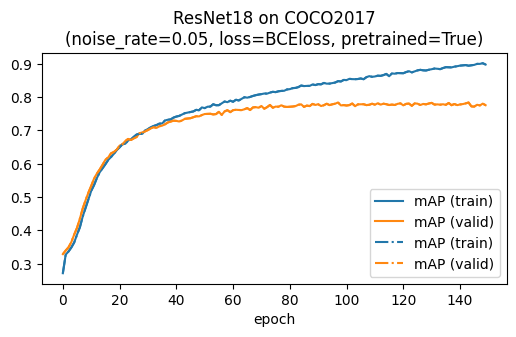

In [38]:
plt.figure(figsize=(6, 3))
plt.plot(meter_train.values['mAP'], '-', color='#27a', label='mAP (train)')
plt.plot(meter_valid.values['mAP'], '-', color='#f81', label='mAP (valid)')
plt.plot(meter_train.values['mAP'], '-.', color='#27a', label='mAP (train)')
plt.plot(meter_valid.values['mAP'], '-.', color='#f81', label='mAP (valid)')
plt.legend()
plt.xlabel('epoch')
plt.title('ResNet18 on COCO2017\n(noise_rate=0.05, loss=BCEloss, pretrained=True)')
plt.show()

## Debug

### Train

In [41]:
model.train()
it = iter(train_loader)

In [42]:
indices, img, img_w, img_s, y_true, y_candidate = next(it)

img_w, img_s = img_w.cuda(), img_s.cuda()
y_candidate, y_true = y_candidate.cuda(), y_true.cuda()
indices = indices.cuda()
batch_size, num_classes = y_candidate.shape

### Visualize

In [229]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean=mean
        self.std=std
 
    def __call__(self, tensor):
        tensor = tensor.clone()
        for t, m, s in zip(tensor,self.mean,self.std):
            t.mul_(s).add_(m)
        return tensor

In [230]:
t = transforms.Compose([
    UnNormalize((0.2443, 0.2394, 0.2425), (0.2443, 0.2394, 0.2425)),
    transforms.ToPILImage()
])

In [248]:
index, image_basic, image_weak_aug, image_strong_aug, y_true, y_candidate = dataset[0]

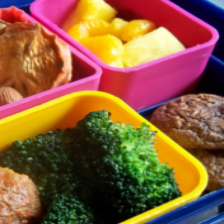

In [252]:
t(image_basic)

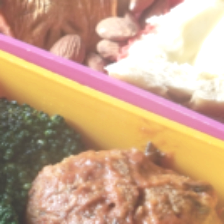

In [253]:
t(image_weak_aug)

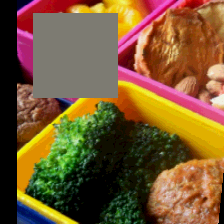

In [254]:
t(image_strong_aug)